In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import qinfer as qi
import models as m
from adaptive import *
from nvdata import *

### Parallelization Setup

The following sets up the `dview` object used for parallelizing models across CPU cores. Go to the Jupyter "IPython Clusters" tab to start up the default cluster.

In [3]:
from ipyparallel import Client
rc = Client()
dview = rc[:]
dview.use_dill()

with dview.sync_imports():
    import os

# Change directory on engines so that we can import models.
if dview.execute('os.chdir("{}")'.format(os.getcwd())).get():
    print "Changed engine directories to notebook directory."

# To ensure that we don't enter into a Matplotlib event loop
# on our engines, we set the MPLBACKEND to the non-interactive
# Agg backend first. This is especially useful if the engines
# are connected via SSH.
if dview.execute('os.environ["MPLBACKEND"] = "Agg"').get():
    print "Changed MPL backend."

# Force each engine to import QInfer before proceeding.
if dview.execute('import qinfer as qi').get():
    print "Successfully imported QInfer on engines."

if dview.execute('import models').get():
    print "Successfully imported models."

print "Engines connected: {}".format(len(rc.ids))

importing os on engine(s)
Changed engine directories to notebook directory.
Changed MPL backend.
Successfully imported QInfer on engines.
Successfully imported models.
Engines connected: 12


### Models

In [4]:
ham_model = m.RabiRamseyModel()
par_ham_model = qi.DirectViewParallelizedModel(ham_model, dview)
ref_model = m.ReferencedPoissonModel(ham_model)

### Convenient Prior for testing risk

`custom_prior(1)` is roughly the posterior after one experimental trial, `custom_prior(200)` is a very wide prior with the same mean.

In [6]:
true_value = np.array([11.6,1.79,1.74778949,2.22,0.61])
target_stds = np.array([0.01,0.01,0.15,0.02,0.05])
def custom_prior(multiplier):
    return qi.ProductDistribution(
        qi.GammaDistribution(mean=true_value[0], var=(multiplier * target_stds[0])**2),
        qi.GammaDistribution(mean=true_value[1], var=(multiplier * target_stds[1])**2),
        qi.NormalDistribution(mean=true_value[2], var=(multiplier * target_stds[2])**2),
        qi.GammaDistribution(mean=true_value[3], var=(multiplier * target_stds[3])**2),
        qi.GammaDistribution(mean=true_value[4], var=(multiplier * target_stds[4])**2),
    )

### Rabi Risk

<IPython.core.display.Javascript object>


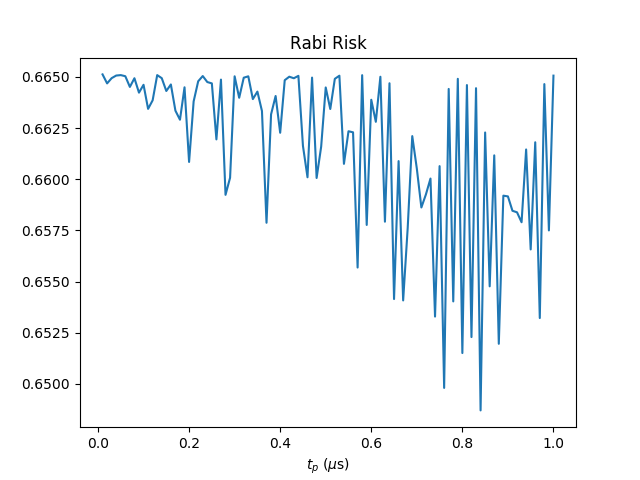

In [18]:
updater = qi.SMCUpdater(par_ham_model, 1000, custom_prior(5))

rabi_eps = rabi_sweep(max_t=1, n=100, wo=0)
fig = plt.figure()
plt.plot(rabi_eps['t'], updater.bayes_risk(rabi_eps))
plt.title('Rabi Risk')
plt.xlabel(r'$t_p$ ($\mu$s)')

### Ramsey Risk

<IPython.core.display.Javascript object>


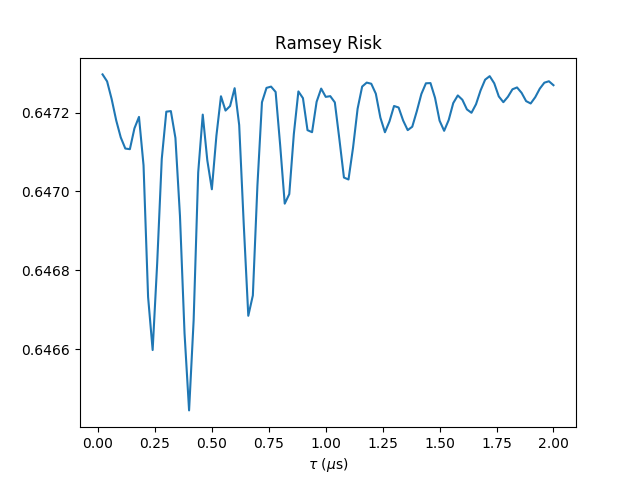

In [19]:
updater = qi.SMCUpdater(par_ham_model, 1000, custom_prior(5))

ramsey_eps = ramsey_sweep(max_tau=2, n=100, tp=0.022, wo=0)
fig = plt.figure()
plt.plot(ramsey_eps['tau'], updater.bayes_risk(ramsey_eps))
plt.title('Ramsey Risk')
plt.xlabel(r'$\tau$ ($\mu$s)')

### 2D Normalized Risk Image

In [20]:
mults = np.array([1,10,100])
wos = np.linspace(-10,10,31)
n_wos = wos.size
n_mults = mults.size
rabi_risk_wo = np.empty((n_mults,n_wos,rabi_eps.size))
ramsey_risk_wo = np.empty((n_mults,n_wos,ramsey_eps.size))

for idx_mult in range(n_mults):
    ham_model._Q = np.array([0,1,0,0,0])
    updater = qi.SMCUpdater(par_ham_model, 1000, custom_prior(mults[idx_mult]))
    risk0 = np.dot(np.diag(updater.est_covariance_mtx()), updater.model.Q)
    for idx_wo in range(n_wos):
        rabi_eps = rabi_sweep(max_t=1,n=100,wo=wos[idx_wo])
        ramsey_eps = ramsey_sweep(max_tau=2,n=100,tp=0.022,wo=wos[idx_wo])
        rabi_risk_wo[idx_mult,idx_wo, :] = updater.bayes_risk(rabi_eps) / risk0
        ramsey_risk_wo[idx_mult,idx_wo, :] = updater.bayes_risk(ramsey_eps) / risk0

<IPython.core.display.Javascript object>


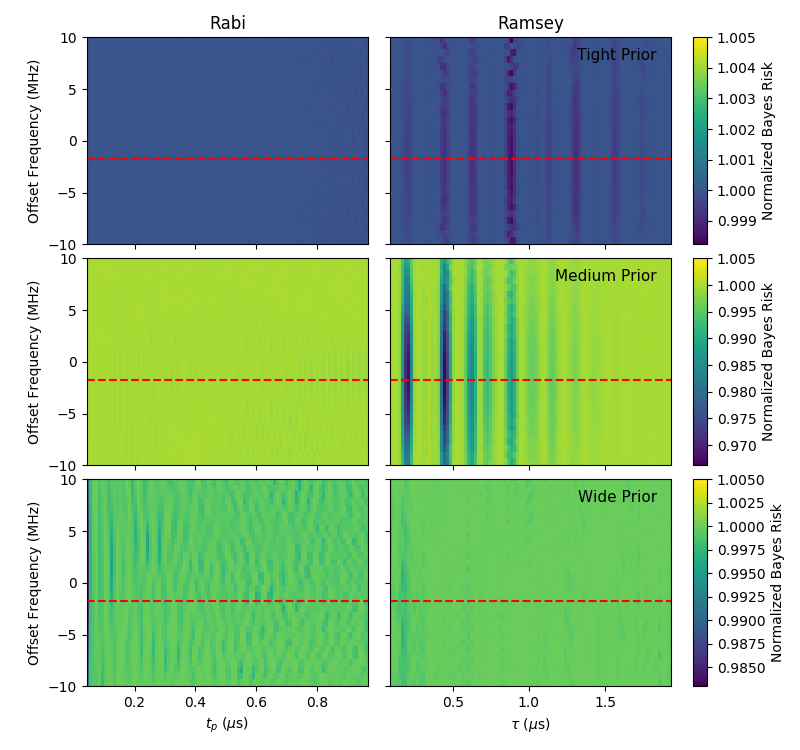

In [21]:
fig = plt.figure(figsize=(8,n_mults * 2.5))
gs = gridspec.GridSpec(n_mults,3, width_ratios=[1,1,0.05])
plt.rc('text', usetex=False)

aspect=0.017 * 2
mult_names = ['Tight Prior','Medium Prior','Wide Prior']

for idx_mult in range(n_mults):
    
    vmin = np.concatenate([rabi_risk_wo[idx_mult,...].flatten(), ramsey_risk_wo[idx_mult,...].flatten()]).min()
    vmax = np.concatenate([rabi_risk_wo[idx_mult,...].flatten(), ramsey_risk_wo[idx_mult,...].flatten()]).max()
    vmax = 1.005

    x_axis = rabi_eps['t']
    y_axis = wos
    ax_rabi = plt.subplot(gs[idx_mult,0])
    im_rabi = plt.imshow(
        rabi_risk_wo[idx_mult, ...], 
        aspect=aspect,
        extent=[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()],
        vmin=vmin, vmax=vmax#norm=LogNorm(vmin=vmin, vmax=vmax)
    )
    ax_rabi.invert_yaxis()
    if idx_mult == 0:
        plt.title('Rabi')
    if idx_mult == n_mults - 1:
        plt.xlabel('$t_p$ ($\mu$s)')
    else:
        plt.setp(ax_rabi.get_xticklabels(), visible=False)
    plt.ylabel('Offset Frequency (MHz)')
    plt.axhline(-true_value[1], color='r', linestyle='--')

    x_axis = ramsey_eps['tau']
    y_axis = wos
    ax_ramsey = plt.subplot(gs[idx_mult,1], sharey=ax_rabi)
    im_ramsey = plt.imshow(
        ramsey_risk_wo[idx_mult, ...],
        extent=[x_axis.min(), x_axis.max(), y_axis.min(), y_axis.max()],
        aspect=aspect * ramsey_eps['tau'].max() / rabi_eps['t'].max(),
        vmin=vmin, vmax=vmax
    )
    if idx_mult == 0:
        plt.title('Ramsey')
    if idx_mult == n_mults - 1:
        plt.xlabel(r'$\tau$ ($\mu$s)')
    else:
        plt.setp(ax_ramsey.get_xticklabels(), visible=False)
    plt.axhline(-true_value[1], color='r', linestyle='--')
    plt.text(0.95,0.95,mult_names[idx_mult], size=11, horizontalalignment='right',
        verticalalignment='top', color='black',transform=plt.gca().transAxes)

    ax_cbar = plt.subplot(gs[idx_mult,2])
    fig.colorbar(im_rabi, cax=ax_cbar)#, ticks=np.arange(21)/20)
    plt.ylabel('Normalized Bayes Risk')

    plt.setp(ax_ramsey.get_yticklabels(), visible=False)
    gs.tight_layout(fig, h_pad=0)

### Risk Heuristic

In [27]:
drift_prior = qi.UniformDistribution(
    [[0.017,0.021],[0.014,0.017]]
)
ada = qi.ProductDistribution(custom_prior(2), drift_prior)

adaptive_updater = m.BridgedRPMUpdater(ref_model, 5000, wide_prior)

heuristic = RiskHeuristic(
    adaptive_updater, 
    [1,1,1,1,1], 
    rabi_sweep(max_t=1, n=100, n_meas=200000), 
    ramsey_sweep(max_tau=2, n=100, n_meas=200000),
    dview=dview
)

print heuristic(0.022)

In [28]:
eps = heuristic(0.022)
for idx in range(5):
    
    eps = heuristic(0.022)

[( 0.02,  0.,  0.,  0., 0, 0, 200000)]
[( 0.02,  0.,  0.,  0., 0, 0, 200000)]
[( 0.02,  0.,  0.,  0., 0, 0, 200000)]
[( 0.02,  0.,  0.,  0., 0, 0, 200000)]
[( 0.02,  0.,  0.,  0., 0, 0, 200000)]
